# Simple Multivariate Time-Series Forecasting

* Ref:
* Data: [Gas sensor array exposed to turbulent gas mixtures Data Set ](https://archive.ics.uci.edu/ml/datasets/Gas+sensor+array+exposed+to+turbulent+gas+mixtures)

* Time series 分成兩種
  * univariate: 只有一個變數與時間有關
  * multivariate: 很多變數都與時間有關

* 做 Multivariate time series analysis
  * 用 Vector Autoregression (VAR) model
  * 要先把 time series 變成 stationary 的，否則的話 Vector Autoregression (VAR) model 沒辦法跑
    * stationary 就是 mean 和 variance 不會隨著時間而改變
    * 用 Augmented Dickey-Fuller test (ADF) 來判斷是不是 stationary 的
    * 每一個欄位都必須要是 stationary 的

* Augmented Dickey-Fuller test (ADF):
  * null hypothesis: time series 不是 stationary 的
    * 有六個輸出:
      * the ADF test statistic
      * p-value
      * number of lags used
      * number of observations used
      * critical values at 1%, 5%, 10% levels
      * the maximized information criterion (icbest)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display

## 1. Load data

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/gas_mixtures.csv',
                 header=0,
                 index_col=0)
df.head()

,Temperature,Relative Humidity,s1,s2,s3,s4,s5,s6,s7,s8
Time,,,,,,,,,,
1.00,21.400000,41.573333,343.444444,292.000000,542.555556,598.444444,593.777778,730.444444,651.666667,745.444444
1.01,21.810000,37.220000,344.000000,298.000000,548.000000,620.000000,597.000000,732.000000,651.000000,746.000000
1.02,21.301481,40.903704,340.370370,292.629630,540.370370,604.000000,587.370370,721.666667,644.925926,737.666667
1.03,21.464444,40.976111,344.666667,292.388889,544.722222,611.833333,597.444444,734.388889,656.333333,750.166667
1.04,21.501579,41.297895,343.210526,290.578947,541.894737,607.894737,595.315789,732.789474,656.105263,750.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 29901 entries, 1.0 to 300.0
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        29901 non-null  float64
 1   Relative Humidity  29901 non-null  float64
 2   s1                 29901 non-null  float64
 3   s2                 29901 non-null  float64
 4   s3                 29901 non-null  float64
 5   s4                 29901 non-null  float64
 6   s5                 29901 non-null  float64
 7   s6                 29901 non-null  float64
 8   s7                 29901 non-null  float64
 9   s8                 29901 non-null  float64
dtypes: float64(10)
memory usage: 2.5 MB


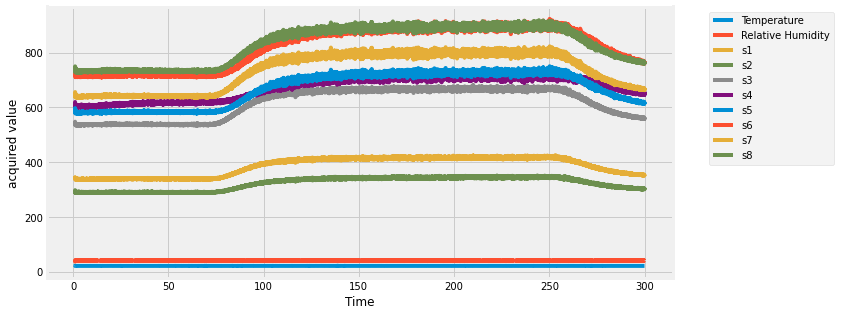

In [ ]:
# Show the time series distribution
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax)
ax.set_ylabel('acquired value')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

* 因為 Temperature 和 Relative Humidity 兩個欄位並不隨著時間而改變，所以把這兩個欄位拿掉，用剩下的 s1 ~ s8 來做 multivariate time series analysis

In [ ]:
df.drop(['Temperature', 'Relative Humidity'], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 29901 entries, 1.0 to 300.0
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s1      29901 non-null  float64
 1   s2      29901 non-null  float64
 2   s3      29901 non-null  float64
 3   s4      29901 non-null  float64
 4   s5      29901 non-null  float64
 5   s6      29901 non-null  float64
 6   s7      29901 non-null  float64
 7   s8      29901 non-null  float64
dtypes: float64(8)
memory usage: 2.1 MB


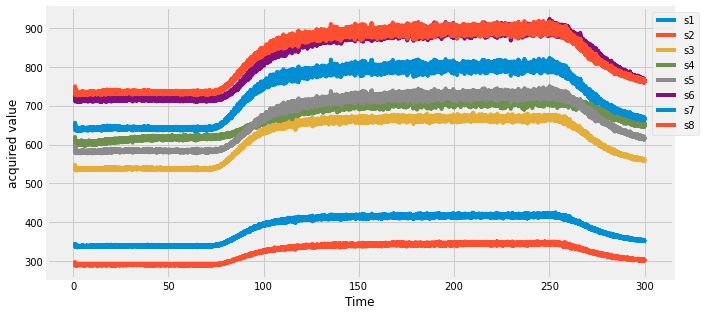

In [ ]:
# Show the time series distribution
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax)
ax.set_ylabel('acquired value')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

## 2. Analysis

* 因為要用 VAR 建 model，所以要先用 ADF 檢查 time series 是不是 stationary 的

In [ ]:
def adf_test(time_series):
    # perform Dickey-Fuller test
    # null hypothesis: the time series is non-stationary 
    from statsmodels.tsa.stattools import adfuller # Use augmented dickey-fuller test to check stationality

    print('Results of Dickey-Fuller test:')
    adf_test = adfuller(time_series, autolag='AIC') # AIC: Akaike information criterion (AIC), the smaller AIC the better model

    index = [
      'Test statistics (ADF)',
      'p-value',
      'Number of lags used',
      'Number of observations used'
    ]
    adf_results = pd.Series(adf_test[:4], index=index)

    for k, v in adf_test[4].items():
      adf_results[f'Critical value ({k})'] = v

    print(adf_results)

    if adf_results[1] <= 0.05:
        print('Because p <= 0.05, we reject the null hypothesis')
        print('--> The time series is stationary')
    else:
        print('The time series is non-stationary')

In [ ]:
for col in df.columns:
  print(f'ADF test for {col}:')
  print('-'* 50)
  adf_test(df[col])
  print('\n')

ADF test for s1:
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Results of Dickey-Fuller test:
Test statistics (ADF)             -1.151102
p-value                            0.694269
Number of lags used               49.000000
Number of observations used    29851.000000
Critical value (1%)               -3.430569
Critical value (5%)               -2.861637
Critical value (10%)              -2.566822
dtype: float64
The time series is non-stationary


ADF test for s2:
--------------------------------------------------
Results of Dickey-Fuller test:
Test statistics (ADF)             -1.267385
p-value                            0.643958
Number of lags used               50.000000
Number of observations used    29850.000000
Critical value (1%)               -3.430569
Critical value (5%)               -2.861637
Critical value (10%)              -2.566822
dtype: float64
The time series is non-stationary


ADF test for s3:
--------------------------------------------------
Results of Dickey-Fuller test:
Test statistics (ADF)             -1.175596
p-value  

* 因為 8 個 time series 都是 non-stationary 所以都要做 differencing
  * 做完 differencing 之後要再檢查一次 stationary
* 第一 row 因為沒有前面的東西可以減去，所以會是 NaN，要丟掉

In [ ]:
df1 = df.diff()
display(df1.head())
df1.info()

,s1,s2,s3,s4,s5,s6,s7,s8
Time,,,,,,,,
1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.01,0.555556,6.000000,5.444444,21.555556,3.222222,1.555556,-0.666667,0.555556
1.02,-3.629630,-5.370370,-7.629630,-16.000000,-9.629630,-10.333333,-6.074074,-8.333333
1.03,4.296296,-0.240741,4.351852,7.833333,10.074074,12.722222,11.407407,12.500000
1.04,-1.456140,-1.809942,-2.827485,-3.938596,-2.128655,-1.599415,-0.228070,-0.166667


<class 'pandas.core.frame.DataFrame'>
Float64Index: 29901 entries, 1.0 to 300.0
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s1      29900 non-null  float64
 1   s2      29900 non-null  float64
 2   s3      29900 non-null  float64
 3   s4      29900 non-null  float64
 4   s5      29900 non-null  float64
 5   s6      29900 non-null  float64
 6   s7      29900 non-null  float64
 7   s8      29900 non-null  float64
dtypes: float64(8)
memory usage: 2.1 MB


In [ ]:
df1.dropna(inplace=True)
display(df1.head())
df1.info()

,s1,s2,s3,s4,s5,s6,s7,s8
Time,,,,,,,,
1.01,0.555556,6.000000,5.444444,21.555556,3.222222,1.555556,-0.666667,0.555556
1.02,-3.629630,-5.370370,-7.629630,-16.000000,-9.629630,-10.333333,-6.074074,-8.333333
1.03,4.296296,-0.240741,4.351852,7.833333,10.074074,12.722222,11.407407,12.500000
1.04,-1.456140,-1.809942,-2.827485,-3.938596,-2.128655,-1.599415,-0.228070,-0.166667
1.05,-1.610526,-1.428947,-1.794737,4.505263,-4.565789,-5.889474,-4.805263,-5.700000


<class 'pandas.core.frame.DataFrame'>
Float64Index: 29900 entries, 1.01 to 300.0
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s1      29900 non-null  float64
 1   s2      29900 non-null  float64
 2   s3      29900 non-null  float64
 3   s4      29900 non-null  float64
 4   s5      29900 non-null  float64
 5   s6      29900 non-null  float64
 6   s7      29900 non-null  float64
 7   s8      29900 non-null  float64
dtypes: float64(8)
memory usage: 2.1 MB


* 檢查 differencing 之後是否還有 non-stationary 的 time series

In [ ]:
for col in df1.columns:
  print(f'ADF test for {col}:')
  print('-'* 50)
  adf_test(df1[col])
  print('\n')

ADF test for s1:
--------------------------------------------------
Results of Dickey-Fuller test:
Test statistics (ADF)            -31.930071
p-value                            0.000000
Number of lags used               50.000000
Number of observations used    29849.000000
Critical value (1%)               -3.430569
Critical value (5%)               -2.861637
Critical value (10%)              -2.566822
dtype: float64
Because p <= 0.05, we reject the null hypothesis
--> The time series is stationary


ADF test for s2:
--------------------------------------------------
Results of Dickey-Fuller test:
Test statistics (ADF)            -33.110371
p-value                            0.000000
Number of lags used               49.000000
Number of observations used    29850.000000
Critical value (1%)               -3.430569
Critical value (5%)               -2.861637
Critical value (10%)              -2.566822
dtype: float64
Because p <= 0.05, we reject the null hypothesis
--> The time series is

* 做過 differencing 之後，全部都變成 stationary 了

## 3. Forecast

* 這個實驗總共有 300 秒，前 60 秒什麼事情都沒有，然後從 60 秒之後打開閥門釋放 (乙烯, 甲烷) 或(乙烯, 一氧化碳) 的混和氣體，釋放時間為 180 秒，然後時間一到又關掉，最後的 60 秒是用來讓系統自動恢復
* 所以分 train, test 時，用前 200 秒當作 training 來預測後 100 秒

In [ ]:
df1[df1.index > 200].head()

,s1,s2,s3,s4,s5,s6,s7,s8
Time,,,,,,,,
200.01,-3.808824,-1.100315,-3.373096,-2.197479,-13.040376,-17.146993,-15.291492,-14.938550
200.02,4.294118,1.263305,3.593838,6.344538,15.162465,19.956583,16.714286,14.322129
200.03,-4.142986,-2.140875,-4.125189,-4.793213,-8.908748,-11.593363,-10.619910,-7.403771
200.04,0.977868,0.283806,0.457490,4.225101,2.987179,4.443725,5.051282,2.277868
200.05,-1.115630,-0.822967,-0.978469,-3.442584,0.003030,-1.032536,-0.393939,4.393461


In [ ]:
df_train = df1[df1.index <= 200]
df_test = df1[df1.index > 200]

print(len(df_train))
display(df_train.head())

print(len(df_test))
display(df_test.head())

19900


,s1,s2,s3,s4,s5,s6,s7,s8
Time,,,,,,,,
1.01,0.555556,6.000000,5.444444,21.555556,3.222222,1.555556,-0.666667,0.555556
1.02,-3.629630,-5.370370,-7.629630,-16.000000,-9.629630,-10.333333,-6.074074,-8.333333
1.03,4.296296,-0.240741,4.351852,7.833333,10.074074,12.722222,11.407407,12.500000
1.04,-1.456140,-1.809942,-2.827485,-3.938596,-2.128655,-1.599415,-0.228070,-0.166667
1.05,-1.610526,-1.428947,-1.794737,4.505263,-4.565789,-5.889474,-4.805263,-5.700000


10000


,s1,s2,s3,s4,s5,s6,s7,s8
Time,,,,,,,,
200.01,-3.808824,-1.100315,-3.373096,-2.197479,-13.040376,-17.146993,-15.291492,-14.938550
200.02,4.294118,1.263305,3.593838,6.344538,15.162465,19.956583,16.714286,14.322129
200.03,-4.142986,-2.140875,-4.125189,-4.793213,-8.908748,-11.593363,-10.619910,-7.403771
200.04,0.977868,0.283806,0.457490,4.225101,2.987179,4.443725,5.051282,2.277868
200.05,-1.115630,-0.822967,-0.978469,-3.442584,0.003030,-1.032536,-0.393939,4.393461


* 建立 VAR model 來做預測
  * https://www.statsmodels.org/devel/generated/statsmodels.tsa.vector_ar.var_model.VAR.html
  * https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html

In [ ]:
from statsmodels.tsa.api import VAR

model = VAR(df_train)
model_fitted = model.fit(maxlags=15, ic='aic') # 用 15 個 lags 來建模型
model_fitted.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 03, Sep, 2020
Time:                     22:46:19
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -4.07576
Nobs:                     19885.0    HQIC:                  -4.33440
Log likelihood:          -180411.    FPE:                  0.0115598
AIC:                     -4.46022    Det(Omega_mle):       0.0110122
--------------------------------------------------------------------
Results for equation s1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.032460         0.008350            3.888           0.000
L1.s1         -1.200143         0.025696          -46.705           0.000
L1.s2          0.030694         0.024325            1.262           0.207
L1.s3         -0.

* 畫 training 預測的結果

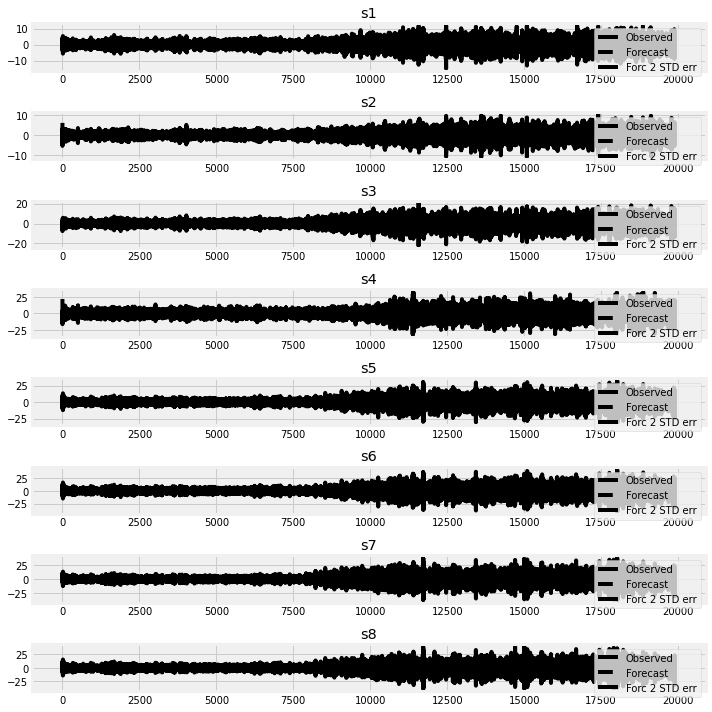

In [ ]:
fig = model_fitted.plot_forecast(1)
fig.tight_layout()

In [ ]:
lag_order = model_fitted.k_ar # k_ar: Order of VAR process
lag_order

15

In [ ]:
# 因為 forecast() 只吃 ndarray 所以要用 df_test.values 把 dataframe 變成 ndaray
testing_samples = df_test.values
length = len(testing_samples)
print(length, testing_samples) 

10000 [[ -3.80882353  -1.10031513  -3.37309611 ... -17.14699317 -15.2914916
  -14.93855042]
 [  4.29411765   1.26330532   3.59383754 ...  19.95658263  16.71428571
   14.32212885]
 [ -4.14298643  -2.14087481  -4.12518854 ... -11.5933635  -10.6199095
   -7.40377074]
 ...
 [ -0.46610971  -1.80564313  -0.92701765 ...  -1.82660782  -0.38571879
   -0.47872005]
 [  0.08166915   2.23204173   1.08733234 ...  -0.12444113  -1.03263785
   -1.26795827]
 [  1.05858586  -1.22020202   0.55656566 ...   2.9992785    2.81197691
    2.90678211]]


In [ ]:
predictions = model_fitted.forecast(testing_samples, length) # length 就是要預測多少筆資料
print(len(predictions), predictions)

10000 [[-1.50666682e+00  5.85857142e-01 -1.25914701e+00 ... -4.14690517e+00
  -3.72735487e+00 -3.69236164e+00]
 [ 1.11573932e+00 -5.31475126e-01  7.94480184e-01 ...  2.52273556e+00
   2.32478877e+00  2.15075598e+00]
 [-1.09380879e+00  5.18519178e-01 -7.71653053e-01 ... -2.24740830e+00
  -2.12838570e+00 -1.95463352e+00]
 ...
 [ 3.76989337e-03  2.70155963e-03  6.34209682e-03 ...  8.28642319e-03
   7.42993583e-03  7.60567032e-03]
 [ 3.76989337e-03  2.70155963e-03  6.34209682e-03 ...  8.28642319e-03
   7.42993583e-03  7.60567032e-03]
 [ 3.76989337e-03  2.70155963e-03  6.34209682e-03 ...  8.28642319e-03
   7.42993583e-03  7.60567032e-03]]


In [ ]:
df_pred = pd.DataFrame(predictions, index = df_test.index, columns=df_test.columns)
df_pred.head()

,s1,s2,s3,s4,s5,s6,s7,s8
Time,,,,,,,,
200.01,-1.506667,0.585857,-1.259147,-7.537686,-2.529194,-4.146905,-3.727355,-3.692362
200.02,1.115739,-0.531475,0.794480,5.568349,1.417856,2.522736,2.324789,2.150756
200.03,-1.093809,0.518519,-0.771653,-5.331483,-1.267692,-2.247408,-2.128386,-1.954634
200.04,0.998306,-0.544738,0.688512,4.943018,0.926324,1.799919,1.695300,1.492242
200.05,-0.968130,0.524551,-0.579142,-4.108757,-0.738197,-1.548129,-1.363646,-1.159674


In [ ]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10000 entries, 200.01 to 300.0
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s1      10000 non-null  float64
 1   s2      10000 non-null  float64
 2   s3      10000 non-null  float64
 3   s4      10000 non-null  float64
 4   s5      10000 non-null  float64
 5   s6      10000 non-null  float64
 6   s7      10000 non-null  float64
 7   s8      10000 non-null  float64
dtypes: float64(8)
memory usage: 703.1 KB


* 雖然預測完了，但是用來預測的輸入是經過 differencing 的，所以預測結果必須要反轉 differencing 才會是真正的結果

In [ ]:
entries = {}
for col in df_pred.columns:
  # 先找出 df_train 的最後一筆資料的 index
  # 然後用這個 index 去找出尚未 differencing 時的數值是多少 
  idx = df_train.index[-1]
  base_value = df[df.index==idx][col].values[0] # 要加上 [col] 變成 series 後，再取值 values 但是這是一個 numpy array 所以還要再用 [0]
  series = base_value + df_pred[col].cumsum()
  entries[col] = series

df_pred_inverse_diff = pd.DataFrame(entries, index=df_pred.index)
df_pred_inverse_diff.head()

,s1,s2,s3,s4,s5,s6,s7,s8
Time,,,,,,,,
200.01,417.243333,346.148357,667.029915,698.962314,726.603619,891.798407,798.085145,894.120138
200.02,418.359073,345.616882,667.824396,704.530663,728.021475,894.321143,800.409934,896.270894
200.03,417.265264,346.135401,667.052743,699.199181,726.753783,892.073735,798.281548,894.316261
200.04,418.263569,345.590663,667.741255,704.142198,727.680107,893.873653,799.976848,895.808503
200.05,417.295439,346.115214,667.162113,700.033441,726.941910,892.325525,798.613202,894.648829


* 最後畫圖比較真實的數據和預測的結果

In [ ]:
index = df_pred_inverse_diff.index[0]
df_test_true = df[index:]
len(df_test_true)
df_test_true.head()

,Temperature,Relative Humidity,s1,s2,s3,s4,s5,s6,s7,s8
Time,,,,,,,,,,
200.01,21.400084,40.634958,414.941176,344.462185,664.915966,704.302521,716.092437,878.798319,786.521008,882.873950
200.02,21.462941,41.234510,419.235294,345.725490,668.509804,710.647059,731.254902,898.754902,803.235294,897.196078
200.03,21.412077,40.549538,415.092308,343.584615,664.384615,705.853846,722.346154,887.161538,792.615385,889.792308
200.04,21.455789,41.109211,416.070175,343.868421,664.842105,710.078947,725.333333,891.605263,797.666667,892.070175
200.05,21.411364,40.492364,414.954545,343.045455,663.863636,706.636364,725.336364,890.572727,797.272727,896.463636


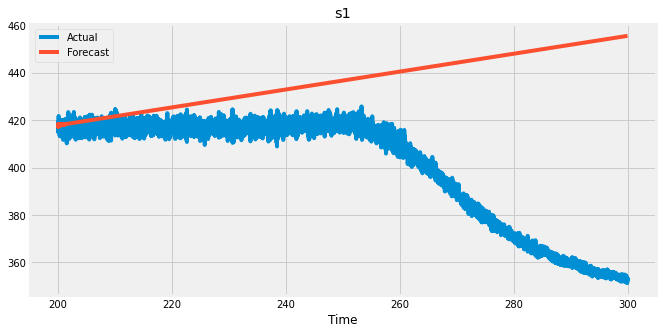

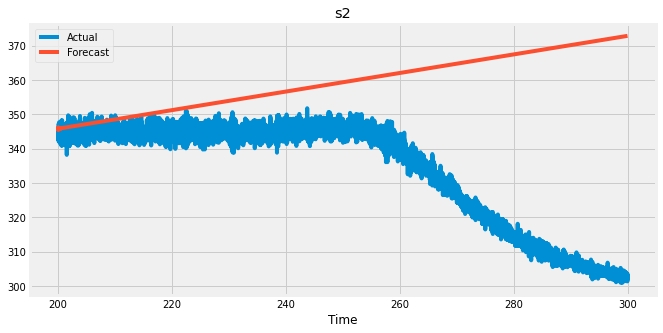

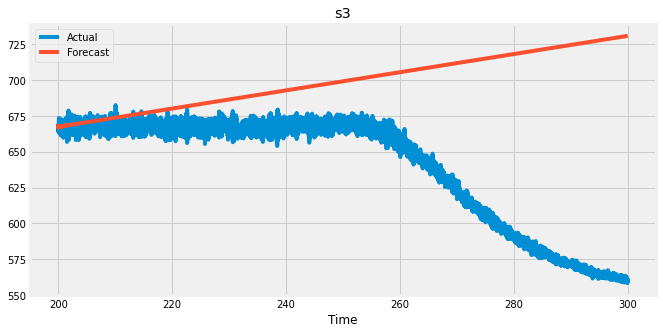

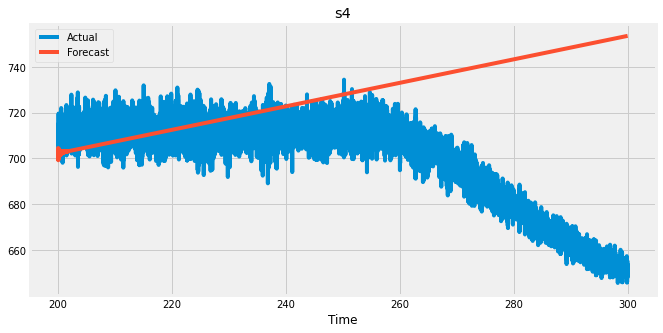

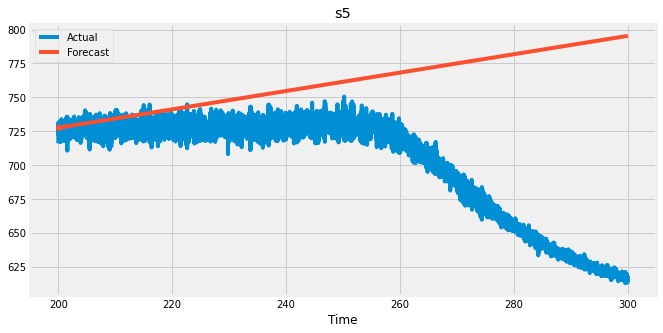

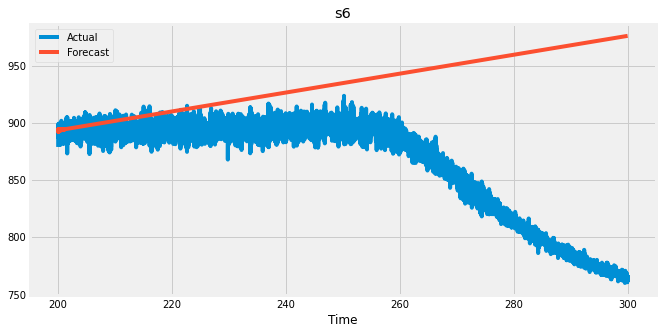

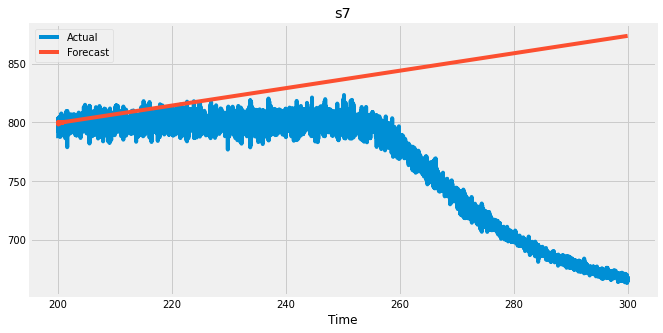

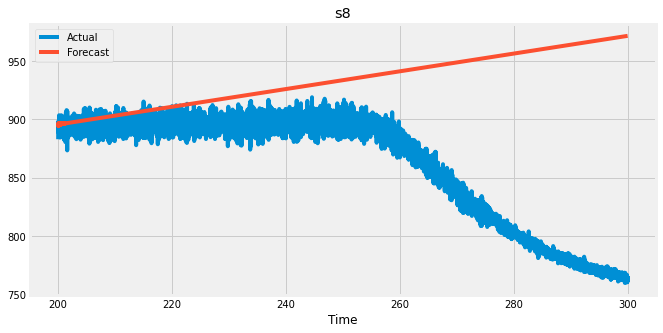

In [ ]:
for col in df_pred_inverse_diff.columns:
  fig, ax = plt.subplots(figsize=(10, 5))
  df_test_true[col].plot(ax=ax, label='Actual')
  df_pred_inverse_diff[col].plot(ax=ax, label='Forecast')
  ax.set_title(col)
  plt.legend()
  plt.show()

* 計算 mean squared error

In [ ]:
# MSE
cols = df_pred_inverse_diff.columns
df_test_true[cols].head()

,s1,s2,s3,s4,s5,s6,s7,s8
Time,,,,,,,,
200.01,414.941176,344.462185,664.915966,704.302521,716.092437,878.798319,786.521008,882.873950
200.02,419.235294,345.725490,668.509804,710.647059,731.254902,898.754902,803.235294,897.196078
200.03,415.092308,343.584615,664.384615,705.853846,722.346154,887.161538,792.615385,889.792308
200.04,416.070175,343.868421,664.842105,710.078947,725.333333,891.605263,797.666667,892.070175
200.05,414.954545,343.045455,663.863636,706.636364,725.336364,890.572727,797.272727,896.463636


In [ ]:
y_true = df_test_true[cols].values
y_pred = df_pred_inverse_diff.values

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true, df_pred_inverse_diff.values)
print(f'Mean squared error = {mse}')

Mean squared error = 6036.034574453055
